###**Practical 4 and 5**

**Name:** Yesha Pandya

**Enrollment Number:** 23BT04175

**Div:** 1 **Batch:** C

**Pre-req: Setup and Initialization**

In [ ]:
#import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#helper function to display images side-by-side for comparison
def show_comparison(img1, img2, title1="Original", title2="Processed", cmap='gray'):
    plt.figure(figsize=(12, 6))

    #plot Image 1
    plt.subplot(1, 2, 1)
    if len(img1.shape) == 3:
        plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img1, cmap='gray')
    plt.title(title1)
    plt.axis('off')

    #plot Image 2
    plt.subplot(1, 2, 2)
    if len(img2.shape) == 3:
        plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img2, cmap=cmap)
    plt.title(title2)
    plt.axis('off')

    plt.show()

In [ ]:
#load the uploaded image
filename = 'hogwarts image.jpg'
img = cv2.imread(filename)
img_gray = cv2.imread(filename, 0) #load as grayscale for intensity transformations

###**Practical-4**

**Objective:**

Enhance the image using various techniques like Log-transformation, Gamma correction and histogram equalization.

**1. Log Transformation**:

Log transformation maps a narrow range of low input gray level values into a wider range of output values. It is useful for enhancing details in the darker regions of an image.

Formula: $$s = c \cdot \log(1 + r)$$

where $c = \frac{255}{\log(1 + \max(r))}$

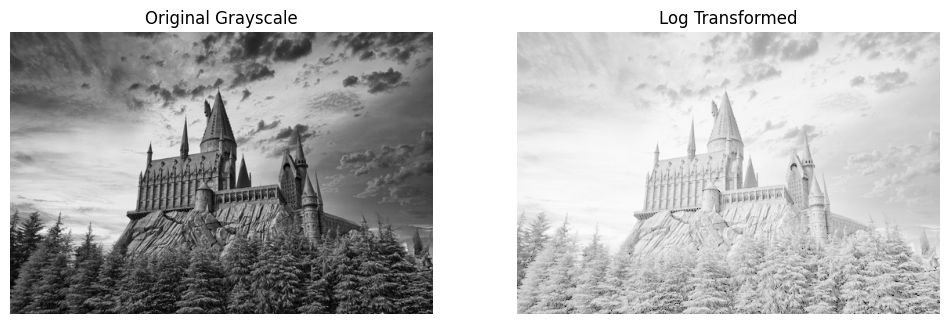

In [ ]:
#convert the image to float32 to prevent overflow (255+1 becoming 0)
img_float = img_gray.astype(np.float32)

#apply Log Transformation Formula
c = 255 / np.log(1 + np.max(img_float))
log_image = c * (np.log(img_float + 1))

#normalize and convert back to uint8 for display
#this ensures values are essentially integers between 0 and 255
log_image = np.array(log_image, dtype=np.uint8)

#display
show_comparison(img_gray, log_image, "Original Grayscale", "Log Transformed")

**2. Power-Law (Gamma) Transformation**

Gamma correction is a non-linear operation used to adjust the luminance.
* $\gamma < 1$: Makes the image brighter (expands dark levels)
* $\gamma > 1$: Makes the image darker (compresses dark levels)

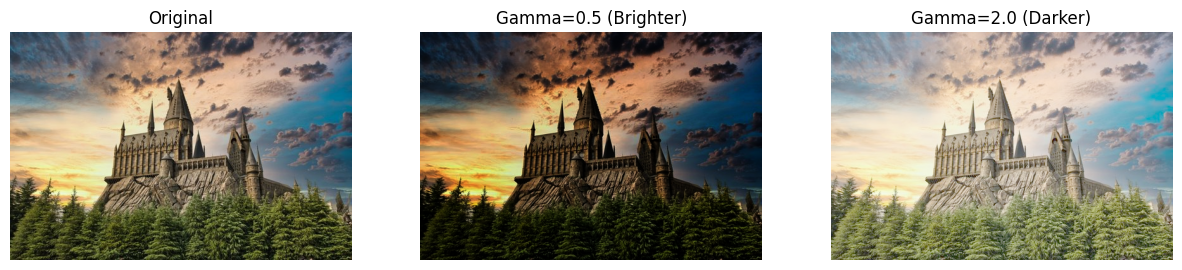

In [ ]:
def adjust_gamma(image, gamma=1.0):
    #build a lookup table mapping the pixel values [0, 255] to their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

#apply different gamma values
gamma_bright = adjust_gamma(img, gamma=0.5) # Brighter
gamma_dark = adjust_gamma(img, gamma=2.0)   # Darker

#display
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title('Original'); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(cv2.cvtColor(gamma_bright, cv2.COLOR_BGR2RGB)); plt.title('Gamma=0.5 (Brighter)'); plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(cv2.cvtColor(gamma_dark, cv2.COLOR_BGR2RGB)); plt.title('Gamma=2.0 (Darker)'); plt.axis('off')
plt.show()

**3. Histogram Equalization**

This technique improves contrast by stretching the intensity distribution of the image so that the histogram spans the entire range (0-255)

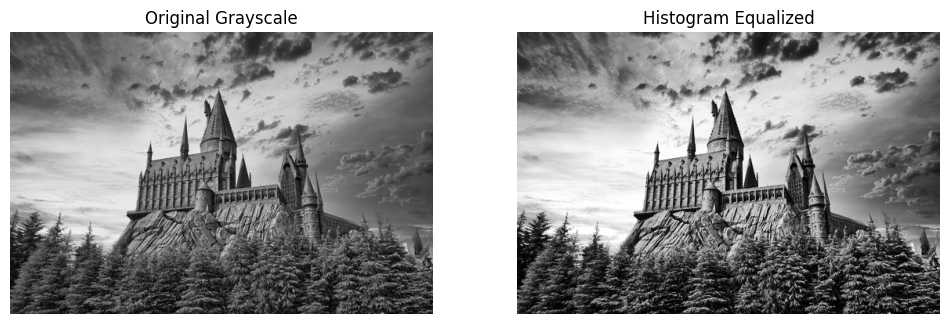

/tmp/ipython-input-440568778.py:9: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.subplot(1, 2, 1); plt.hist(img_gray.ravel(), 256, [0, 256]); plt.title("Original Histogram")
/tmp/ipython-input-440568778.py:10: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.subplot(1, 2, 2); plt.hist(hist_eq.ravel(), 256, [0, 256]); plt.title("Equalized Histogram")


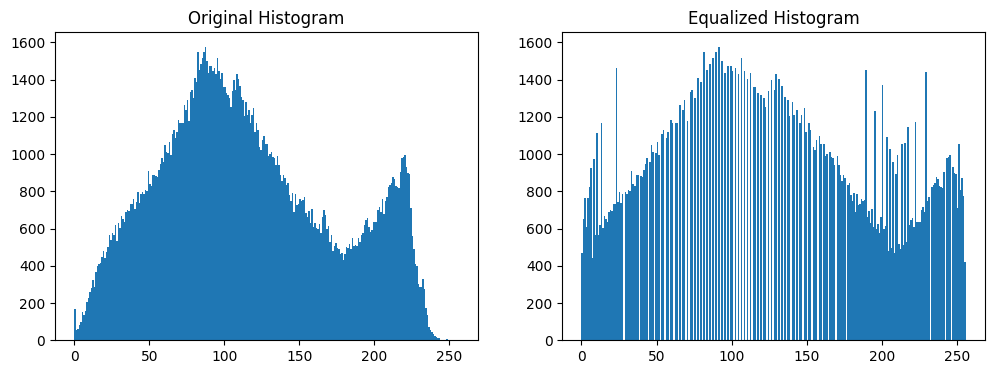

In [ ]:
#histogram Equalization is typically applied to grayscale images
hist_eq = cv2.equalizeHist(img_gray)

#display result
show_comparison(img_gray, hist_eq, "Original Grayscale", "Histogram Equalized")

#plot histograms
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1); plt.hist(img_gray.ravel(), 256, [0, 256]); plt.title("Original Histogram")
plt.subplot(1, 2, 2); plt.hist(hist_eq.ravel(), 256, [0, 256]); plt.title("Equalized Histogram")
plt.show()

###**Practical-5**

**Objective:**

Apply various Linear Filters and Median Filters on the given image.

1. **Linear Filters (Average & Gaussian)**

* Average Filter: Computes the average of pixels in the kernel area. It smooths the image but blurs edges.

* Gaussian Filter: Uses a weighted average (Gaussian distribution). It is more effective at smoothing while preserving natural structures compared to a simple box filter.

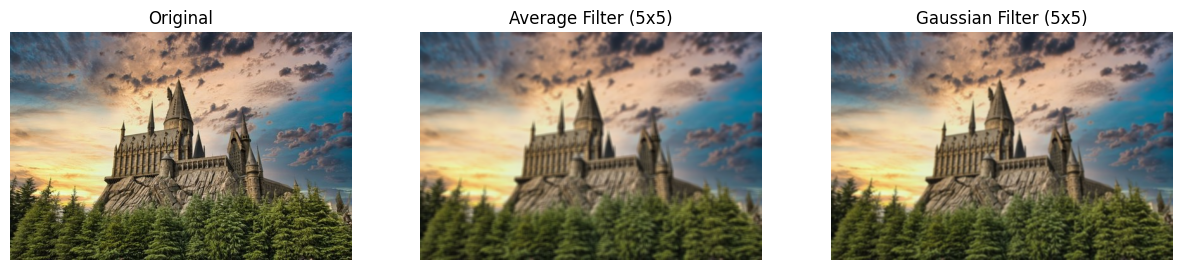

In [ ]:
#average (box) filter
kernel_size = (5, 5)
blur_avg = cv2.blur(img, kernel_size)

#gaussian filter
blur_gauss = cv2.GaussianBlur(img, kernel_size, 0)

#display comparison
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title('Original'); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(cv2.cvtColor(blur_avg, cv2.COLOR_BGR2RGB)); plt.title('Average Filter (5x5)'); plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(cv2.cvtColor(blur_gauss, cv2.COLOR_BGR2RGB)); plt.title('Gaussian Filter (5x5)'); plt.axis('off')
plt.show()

**2. Median Filter (Order-Statistic)**

The Median filter replaces a pixel with the median value of its neighbors. It is excellent for removing "Salt-and-Pepper" noise (impulse noise) while preserving sharp edges.

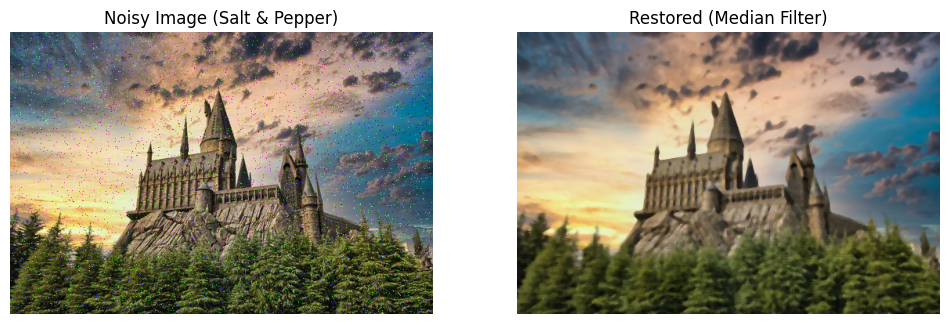

In [ ]:
#step 1: add artificial 'Salt and Pepper' noise to demonstrate the filter
def add_salt_pepper_noise(image, amount=0.02):
    row, col, ch = image.shape
    noisy = np.copy(image)

    #salt (white pixels)
    num_salt = np.ceil(amount * image.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy[tuple(coords)] = 255

    #pepper (black pixels)
    num_pepper = np.ceil(amount * image.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy[tuple(coords)] = 0
    return noisy

noisy_img = add_salt_pepper_noise(img)

#step 2: apply median filter
#ksize must be an odd integer greater than 1
median_filtered = cv2.medianBlur(noisy_img, 5)

#display
show_comparison(noisy_img, median_filtered, "Noisy Image (Salt & Pepper)", "Restored (Median Filter)")